In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("movies.csv", low_memory=False)

# Prepare the dataset
df['title_lower'] = df['title'].str.lower()

# Function to get movie info from user input
def get_movie_info():
    movie_name = input("Enter a movie name: ").strip().lower()
    result = df[df['title_lower'].str.contains(movie_name, na=False)]

    if result.empty:
        print("\n Movie not found.")
    else:
        print("\n Movie Details:")
        for _, row in result.iterrows():
            print(f"\nTitle: {row['title']}")
            print(f"Rating: {row['vote_average']}")
            print(f"Votes: {row['vote_count']}")
            print(f"Popularity: {row.get('popularity', 'N/A')}")
            print(f"Budget: {row.get('budget', 'N/A')}")
            print(f"Revenue: {row.get('revenue', 'N/A')}")
            print(f"Runtime: {row.get('runtime', 'N/A')} minutes")
            print(f"Release Date: {row.get('release_date', 'N/A')}")
            print(f"Overview: {row.get('overview', 'N/A')}")
            break  # Show only the first match

# Function to suggest best movies
def suggest_best_movies(n=5):
    filtered = df.dropna(subset=['vote_average', 'vote_count']).copy()

    # Convert to numeric
    filtered['vote_average'] = pd.to_numeric(filtered['vote_average'], errors='coerce')
    filtered['vote_count'] = pd.to_numeric(filtered['vote_count'], errors='coerce')

    top_movies = filtered.sort_values(by=['vote_average', 'vote_count'], ascending=False).head(n)

    print("\n Top Rated and Most Voted Movies:")
    for i, (_, row) in enumerate(top_movies.iterrows(), 1):
        print(f"{i}. {row['title']} - Rating: {row['vote_average']} - Votes: {row['vote_count']}")

# Main menu
if __name__ == "__main__":
    while True:
        print("\n Movie Explorer")
        print("1. Search for a movie")
        print("2. Show top rated movies")
        print("3. Exit")
        choice = input("Enter your choice (1/2/3): ").strip()

        if choice == '1':
            get_movie_info()
        elif choice == '2':
            suggest_best_movies()
        elif choice == '3':
            print(" Goodbye!")
            break
        else:
            print("Invalid choice. Please enter 1, 2 or 3.")



 Movie Explorer
1. Search for a movie
2. Show top rated movies
3. Exit


Enter your choice (1/2/3):  3


 Goodbye!


In [4]:
#Top Rated and Most Voted Movies

import pandas as pd

# Load the dataset
df = pd.read_csv("movies.csv", low_memory=False)

def suggest_best_movies(n=5):
    # Drop rows with missing vote counts or ratings
    filtered = df.dropna(subset=['vote_average', 'vote_count']).copy()
    
    # Convert to numeric
    filtered['vote_average'] = pd.to_numeric(filtered['vote_average'], errors='coerce')
    filtered['vote_count'] = pd.to_numeric(filtered['vote_count'], errors='coerce')

    # Sort by rating and vote count
    top_movies = filtered.sort_values(by=['vote_average', 'vote_count'], ascending=False).head(n)
    
    print(" Top Rated and Most Voted Movies:")
    for _, row in top_movies.iterrows():
        print(f"{row['title']} - Rating: {row['vote_average']} - Votes: {row['vote_count']}")

# Example usage
suggest_best_movies()

 Top Rated and Most Voted Movies:
Butterfly - Rating: 10.0 - Votes: 3.0
Mera Naam Joker - Rating: 10.0 - Votes: 3.0
Maidan - Rating: 10.0 - Votes: 3.0
Avetik - Rating: 10.0 - Votes: 3.0
Frankie Boyle: Hurt Like You've Never Been Loved - Rating: 10.0 - Votes: 3.0


In [5]:
def is_movie_recommended():
    movie_name = input("Enter a movie name: ").strip()
    movie = df[df['title'].str.lower() == movie_name.lower()]
    
    if movie.empty:
        print(f"\n Movie '{movie_name}' not found in the dataset.")
        return

    row = movie.iloc[0]
    rating = row['vote_average']
    votes = row['vote_count']
    
    print(f"\n Title: {row['title']}")
    print(f" Rating: {rating}")
    print(f" Votes: {votes}")
    
    if rating >= 7.0 and votes >= 1000:
        print(" This movie is recommended to watch!")
    else:
        print(" This movie might not be highly recommended based on ratings and votes.")

# Call the function
is_movie_recommended()

Enter a movie name:  Avenger



 Title: Avenger
 Rating: 4.8
 Votes: 6.0
 This movie might not be highly recommended based on ratings and votes.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Load dataset
df = pd.read_csv("movies.csv", low_memory=False)

# === 1. Basic Overview ===
print("\n🔍 Basic Info:")
print(df.info())
print("\n📊 Summary Statistics:")
print(df.describe(include='all'))

# === 2. Remove Duplicates ===
df = df.drop_duplicates(subset='title')
print(f"\n✅ Removed duplicates. New shape: {df.shape}")

# === 3. Handle Missing Values ===
missing_percent = df.isnull().mean() * 100
print("\n🧼 Missing Data (%):")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

# Fill NaNs for common fields
df['overview'] = df['overview'].fillna('')
df['genres'] = df['genres'].fillna('[]')
df['tagline'] = df['tagline'].fillna('No tagline')
df['runtime'] = df['runtime'].fillna(df['runtime'].median())

# Drop columns with too many missing values (optional)
threshold = 0.4  # Drop if more than 40% missing
df = df.loc[:, df.isnull().mean() < threshold]

# === 4. Convert Data Types ===
numeric_cols = ['vote_average', 'vote_count', 'popularity', 'budget', 'revenue', 'runtime']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# === 5. Feature Engineering ===
# Extract year from release_date
df['release_year'] = df['release_date'].dt.year

# Calculate profit
df['profit'] = df['revenue'] - df['budget']

# Clean genres to list
def parse_genres(genre_str):
    try:
        return [d['name'] for d in ast.literal_eval(genre_str)]
    except:
        return []

df['genre_list'] = df['genres'].apply(parse_genres)

# === 6. Filter Meaningful Movies ===
# Keep movies with at least 100 votes and rating >= 5
df_filtered = df[(df['vote_count'] >= 100) & (df['vote_average'] >= 5)].reset_index(drop=True)

print(f"\n🎬 Filtered dataset shape (popular + decent movies): {df_filtered.shape}")

# Top 10 Highest Rated Movies (with at least 1000 votes)
top_rated = df[df['vote_count'] > 1000].sort_values(by='vote_average', ascending=False).head(10)





🔍 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  

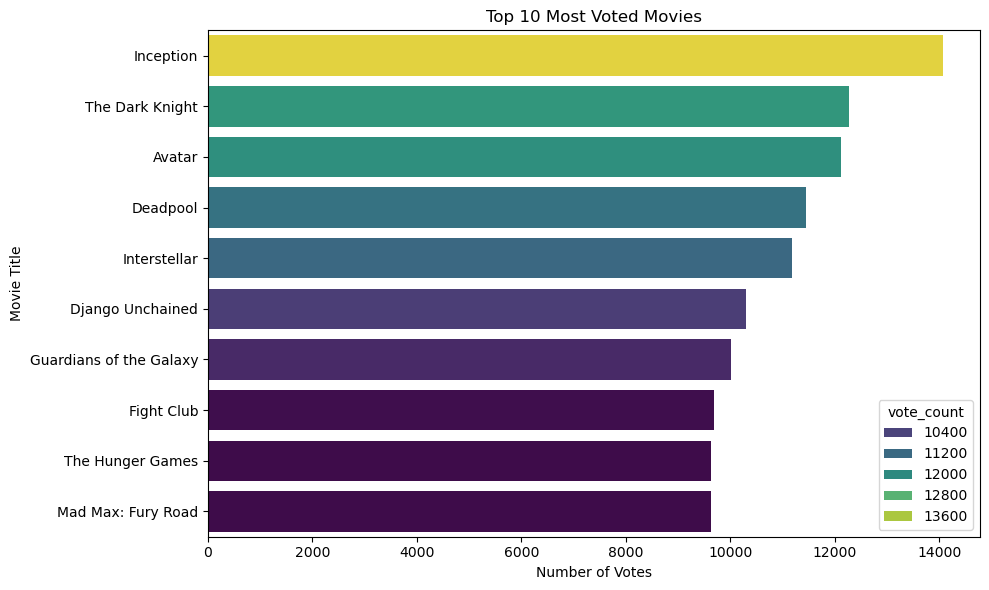

In [6]:
# Top 10 Most Voted Movies
most_voted = df.sort_values(by='vote_count', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='vote_count', y='title', data=most_voted, palette='viridis', hue='vote_count')
plt.title('Top 10 Most Voted Movies')
plt.xlabel('Number of Votes')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

C:\Users\Tejas RajeShirke\AppData\Local\Temp\ipykernel_24980\859776419.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_rating.index, y=genre_rating.values, palette='coolwarm')
C:\Users\Tejas RajeShirke\AppData\Local\Temp\ipykernel_24980\859776419.py:30: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Tejas RajeShirke\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


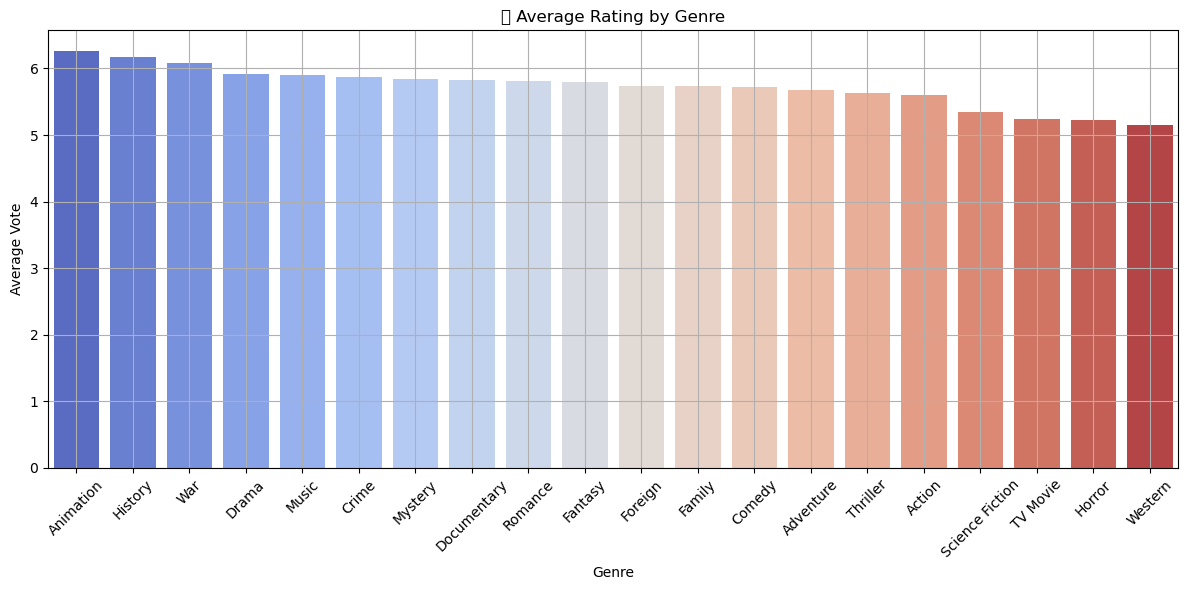

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# --- Step 1: Parse genres ---
def parse_genres(genre_str):
    try:
        return [d['name'] for d in ast.literal_eval(genre_str)]
    except:
        return []

df['genre_list'] = df['genres'].apply(parse_genres)

# --- Step 2: Explode genres to one per row ---
df_exploded = df.explode('genre_list')

# --- Step 3: Group by genre and calculate mean rating ---
genre_rating = df_exploded.groupby('genre_list')['vote_average'].mean().sort_values(ascending=False)

# --- Step 4: Plot ---
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_rating.index, y=genre_rating.values, palette='coolwarm')

plt.title("⭐ Average Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Vote")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


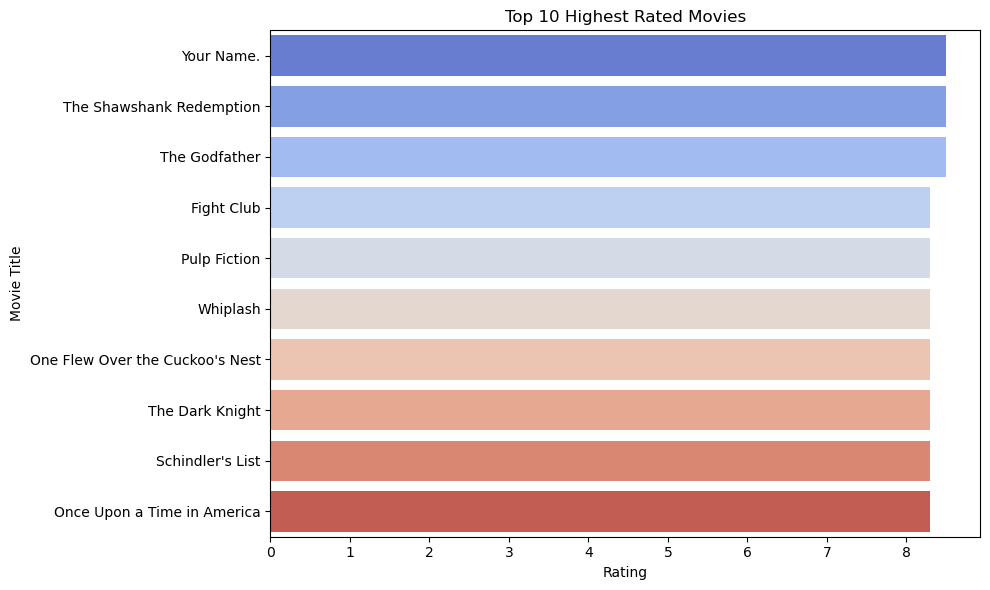

In [8]:
# Top 10 Highest Rated Movies (with at least 1000 votes)
top_rated = df[df['vote_count'] > 1000].sort_values(by='vote_average', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='vote_average', y='title', data=top_rated, hue='title', legend=False, palette='coolwarm')

plt.title('Top 10 Highest Rated Movies')
plt.xlabel('Rating')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()